Use LSA to identify related questions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from multiprocessing import Pool
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
from itertools import chain
from collections import Counter
import pickle
import scipy.io as scio
from sklearn.decomposition import TruncatedSVD
import scipy.spatial.distance as distance
import scipy.cluster.hierarchy as hierarchy
from scipy.stats import pearsonr

In [2]:
dat = pd.read_csv("../raw_data/raw/Questions.csv", encoding='latin1')
dat['Title'].fillna("None", inplace=True)
dat['Score'].fillna(0, inplace=True)

In [3]:
dat.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from it...,<p>I am using the Photoshop's javascript API t...
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,<p>I have a cross-platform (Python) applicatio...
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Cod...,<p>I'm starting work on a hobby project with a...
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a re...
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python obj...,<p>I don't remember whether I was dreaming or ...


In [4]:
# select a sample - results will improve without sampling in tf-idf caluculations, but due to
# Kaggle kernel memory limit we have to make a compromise here.
selected_ids = np.random.choice(range(dat.shape[0]), 10000, replace=False)
sample = dat.loc[selected_ids, :]
sample.shape

(10000, 6)

In [5]:
def purify_string(html):
    return re.sub('(\r\n)+|\r+|\n+', " ", re.sub('<[^<]+?>', '', html))

In [6]:
corpus = sample.loc[:, 'Body'].apply(purify_string)

In [7]:
def combine_title_body(tnb):
    return tnb[0] + " " + tnb[1]

In [8]:
p = Pool(8)
combined_corpus = p.map(combine_title_body, zip(dat['Title'], corpus))
p.close()

In [9]:
combined_corpus[:2]

['How can I find the full path to a font from its display name on a Mac? I started learning Python to use networkx. I am trying to build a hierarchy rooted at some node (node 0), and I want the colors to change according to distance (in hops) from that node. I have written the following code, but I don\'t know why the colors are not changing!! can you please point out the problem? import networkx as nx import matplotlib.pyplot as plt import matplotlib.cm as cmx import random # initial values of rings in nodes MAX_RING = 1000 class Node:     count = int(0)     tx_range = 3     def __init__(self, i):         Node.count+= 1         self.id = int(i)         self.ring = int(MAX_RING)         self.x_pos = int()         self.y_pos = int()         self.parent_list = list()         self.nbr_list = list()         self.color = float()     def addNbr(self, nbr):         self.nbr_list.append(nbr) def createNodes(Nodes, pos, labels):     for i in range(num_of_nodes):         Nodes.append(Node(i))   

In [10]:
lem = WordNetLemmatizer()
def cond_tokenize(t):
    if t is None:
        return []
    else:
        return [lem.lemmatize(w.lower()) for w in word_tokenize(t)]

p = Pool(8)
tokens = list(p.imap(cond_tokenize, combined_corpus))
p.close()

In [11]:
# stops = stopwords.words('english')
pure_tokens = [" ".join(sent) for sent in tokens]

In [12]:
vectorizer = TfidfVectorizer(min_df=1, max_features=2000, stop_words='english', ngram_range=[1, 1], sublinear_tf=True)
tfidf = vectorizer.fit_transform(pure_tokens)

In [13]:
idfs = pd.DataFrame([[v, k] for k, v in vectorizer.vocabulary_.items()], columns=['id', 'word']).sort_values('id')
idfs['idf'] = vectorizer.idf_
idfs.sort_values('idf').head(10)

,id,word,idf
6,1421,python,1.282198
82,1887,using,1.924927
18,412,code,1.952795
80,1049,like,2.018977
141,761,file,2.030400
23,932,import,2.169993
49,1371,print,2.253263
11,1930,want,2.262408
96,1933,way,2.269501
35,550,def,2.298750


### Compress using SVD

In [68]:
tsvd = TruncatedSVD(n_components=500)
transformed = tsvd.fit_transform(tfidf)

In [44]:
np.sum(tsvd.explained_variance_ratio_)

0.25148281688005686

In [45]:
transformed.shape

(10000, 100)

In [46]:
# calculate pairwise cosine distance
D = distance.pdist(transformed, 'cosine')

In [47]:
# hierarchical clustering - tree calculation
L = hierarchy.linkage(D)

In [48]:
# mean distance between clusters
np.mean(D)

0.8439343692922444

In [60]:
# split clusters by criterion. Here 0.71 is used as the inconsistency criterion. Adjust the
# number to change cluster sizes
cls = hierarchy.fcluster(L, 0.7, criterion='inconsistent')

In [61]:
df_cls = pd.DataFrame({'Pos': selected_ids, 'Cluster': cls})
cnts = df_cls.groupby('Cluster').size().sort_values(ascending=False)
cnts.sort_values(ascending=False).head()

Cluster
911     4
3621    4
824     4
1555    4
731     4
dtype: int64

In [62]:
# add clusters to question data
bc = pd.concat([sample, df_cls.set_index('Pos')], axis=1)
bc.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body,Cluster
Pos,,,,,,,
522594,36580641,6194832.0,2016-04-12T17:52:58Z,2,Python networkx: node are not taking color list,<p>I started learning Python to use networkx. ...,5286
420761,31859171,2501747.0,2015-08-06T14:59:04Z,0,Resize shapefile,<p>I have a shapefile for each US state and I ...,8534
301699,25206316,3911452.0,2014-08-08T14:54:52Z,0,Variable area threshold for identifying object...,<p>I have an array which contains information ...,3584
262799,22781227,3224522.0,2014-04-01T09:01:50Z,0,Finding full lengths,<p>I have an input file like this</p>\n\n<pre>...,1272
63432,6866707,868432.0,2011-07-28T22:50:10Z,0,"Tkinter Class ""must be str not tuple"" TypeErro...",<p>I'm getting a problem with Tkinter for pyth...,3748


In [63]:
# calculate cluster stats
stats = bc.groupby('Cluster')['Score'].describe().unstack()

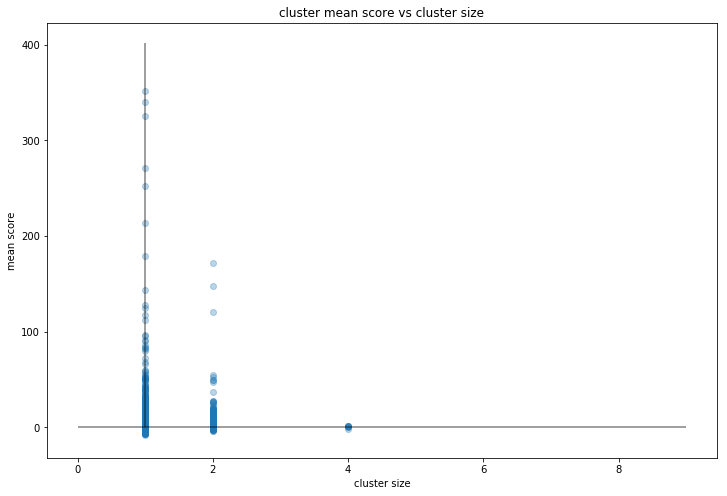

In [64]:
plt.figure(figsize=(12, 8))
plt.hlines([0], xmin=0, xmax=np.max(stats['count']) + 5, alpha=0.5)
plt.vlines([1], ymin=0, ymax=np.max(stats['mean']) + 50, alpha=0.5)
plt.scatter(stats['count'], stats['mean'], alpha=0.3)
plt.title("cluster mean score vs cluster size")
plt.xlabel("cluster size")
plt.ylabel("mean score")
plt.show()

### Check if clusters make sense

In [65]:
bc.loc[bc['Cluster'] == cnts.index[0]][['Score', 'Title', 'Body']]

,Score,Title,Body
Pos,,,
516378,0,Is it possible to query records from a nested ...,<p>I am trying to use blaze for querying data ...
348561,0,Select Specific Fields From JSON File - Python,<p>Im trying to compare two json files. One is...
563983,0,File Open Fails When W+ Argument Used,<p>I have...</p>\n\n<pre><code>datadir = os.pa...
273868,0,"with Python, how can I save a json dumps as a ...",<p>Given the following example data :</p>\n\n<...


In [66]:
bc.loc[bc['Cluster'] == cnts.index[1]][['Score', 'Title', 'Body']]

,Score,Title,Body
Pos,,,
584705,1,Overlay two images without losing the intensit...,<p>How can i overlay two images without losing...
587751,0,Sharp edges after bluring part of image with cv2,<p>I'm using python and opencv to detect skin ...
533207,1,opencv motion tracker with identification,"<p>Currently, the following script works perfe..."
100755,4,Image resize using PIL changes colors drastically,<p>I am using the following code to resize an ...


In [67]:
bc.loc[bc['Cluster'] == cnts.index[2]][['Score', 'Title', 'Body']]

,Score,Title,Body
Pos,,,
505893,0,how to get fill rate of each column in databas...,<p>I can get fill rate of only one column at o...
67789,1,SQLAlchemy Query Dynamic Field,<p>I have a table with many columns --</p>\n\n...
530449,0,How to automate renaming columns in Pandas,<p>I have a data-frame with multiple columns. ...
155671,2,Sqlalchemy: use PSQL's `~` operator when strin...,<p>I know that </p>\n\n<pre><code>WHERE column...


We can improve our clusters by increasing sample size, using entire dataset to calculate tf-idf, adjusting cluster splitting criterion, using non-exclusive clustering techniques etc.

Next steps:

 1. Use clusters and most significant words in questions to generate question tags automatically
 2. Use an autoencoder to perform semantical hashing for better estimates of question relatedness